# Feature Extraction - Images Synthétiques

## Imports

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import six
from radiomics import featureextractor, getFeatureClasses
from radiomics.imageoperations import getMask
from skimage import io as skio


In [2]:
%matplotlib inline


## Hyperparameters

In [3]:
PATH_SYNTHETIQUES = os.path.join(os.getcwd(), "..", "images", "synthetiques")
PATH_RESULTS = os.path.join(os.getcwd(), "results_synthetiques")


In [4]:
if not os.path.exists(PATH_RESULTS):
    os.makedirs(PATH_RESULTS)


In [5]:
carreName = "carre-nb"
imageName = "carre-grad-nb"


In [6]:
np.random.seed(0)


## Function declarations

In [7]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(
            obj,
            (
                np.int_,
                np.intc,
                np.intp,
                np.int8,
                np.int16,
                np.int32,
                np.int64,
                np.uint8,
                np.uint16,
                np.uint32,
                np.uint64,
            ),
        ):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


## Feature extraction

In [8]:
carrePath = os.path.join(PATH_SYNTHETIQUES, carreName + ".tif")
carreArray = skio.imread(carrePath, plugin="matplotlib", format="tif")[:, :, 0] / 255
carre = sitk.GetImageFromArray(carreArray)
carreMask = getMask(carre)


In [9]:
imagePath = os.path.join(PATH_SYNTHETIQUES, imageName + ".tif")
imageArray = skio.imread(imagePath, plugin="matplotlib", format="tif")[:, :, 0] / 255
image = sitk.GetImageFromArray(imageArray)


In [10]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()

result = extractor.execute(image, carreMask)

feature = np.array([])

for key, value in six.iteritems(result):
    if key.startswith("original_"):
        feature = np.append(feature, result[key])


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


## Visualizations

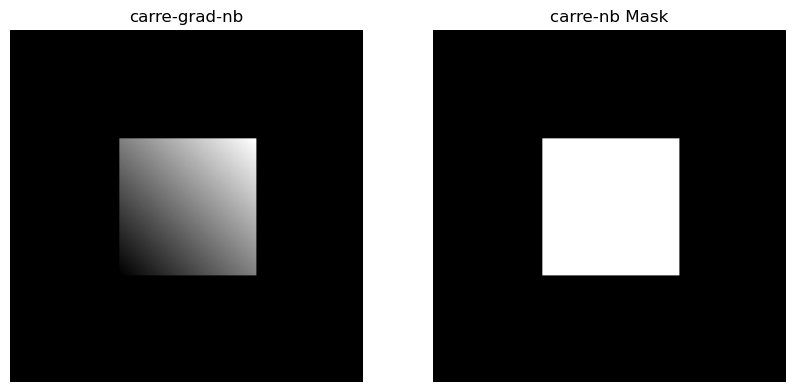

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(imageArray, cmap="gray")
axs[0].set_title(imageName)
axs[0].axis("off")

axs[1].imshow(sitk.GetArrayFromImage(carreMask), cmap="gray")
axs[1].set_title("carre-nb Mask")
axs[1].axis("off")

plt.show()


In [12]:
plt.close(fig)


In [13]:
print("Enabled input images:")
for imageType in extractor.enabledImagetypes.keys():
    print("\t" + imageType)


Enabled input images:
	Original


In [14]:
featureClasses = getFeatureClasses()

print("Active features:")
for cls, features in six.iteritems(extractor.enabledFeatures):
    if len(features) == 0:
        features = [
            f
            for f, deprecated in six.iteritems(featureClasses[cls].getFeatureNames())
            if not deprecated
        ]
    for f in features:
        print(f)
        print(getattr(featureClasses[cls], "get%sFeatureValue" % f).__doc__)


Active features:
10Percentile

    **5. 10th percentile**

    The 10\ :sup:`th` percentile of :math:`\textbf{X}`
    
90Percentile

    **6. 90th percentile**

    The 90\ :sup:`th` percentile of :math:`\textbf{X}`
    
Energy

    **1. Energy**

    .. math::
      \textit{energy} = \displaystyle\sum^{N_p}_{i=1}{(\textbf{X}(i) + c)^2}

    Here, :math:`c` is optional value, defined by ``voxelArrayShift``, which shifts the intensities to prevent negative
    values in :math:`\textbf{X}`. This ensures that voxels with the lowest gray values contribute the least to Energy,
    instead of voxels with gray level intensity closest to 0.

    Energy is a measure of the magnitude of voxel values in an image. A larger values implies a greater sum of the
    squares of these values.

    .. note::
      This feature is volume-confounded, a larger value of :math:`c` increases the effect of volume-confounding.
    
Entropy

    **3. Entropy**

    .. math::
      \textit{entropy} = -\displaystyl

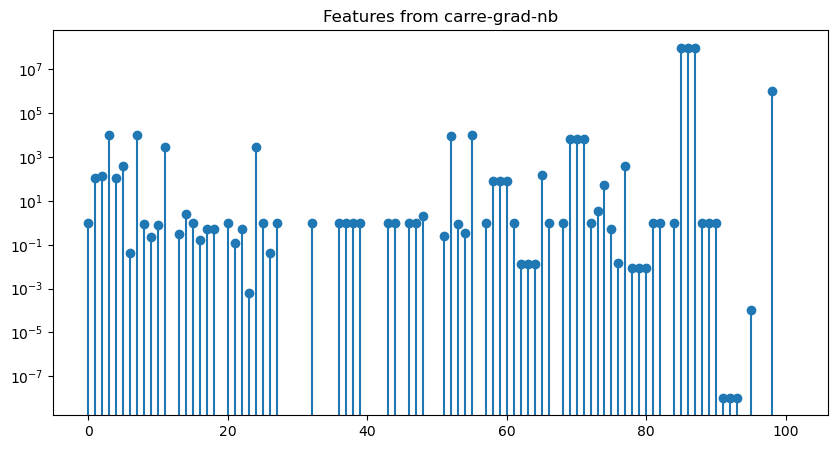

In [15]:
fig = plt.figure(figsize=(10, 5))

plt.stem(feature)
plt.yscale("log")
plt.title("Features from " + imageName)

plt.show()


In [16]:
plt.close(fig)


In [17]:
for featureName in result.keys():
    print("Computed %s: %s" % (featureName, result[featureName]))


Computed diagnostics_Versions_PyRadiomics: v3.1.0
Computed diagnostics_Versions_Numpy: 1.21.5
Computed diagnostics_Versions_SimpleITK: 2.2.1
Computed diagnostics_Versions_PyWavelet: 1.3.0
Computed diagnostics_Versions_Python: 3.7.16
Computed diagnostics_Configuration_Settings: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
Computed diagnostics_Configuration_EnabledImageTypes: {'Original': {}}
Computed diagnostics_Image-original_Hash: 53c0a7227f34de1602fa6cfa5e1794c6b576e893
Computed diagnostics_Image-original_Dimensionality: 2D
Computed diagnostics_Image-original_Spacing: (1.0, 1.0)
Computed diagnostics_Image-original_Size: (255, 255)
Computed diagnostics_Image-original_Mean: 0.07543885835764524
Computed

## Persistency

In [18]:
operation = json.dumps(result, cls=NumpyEncoder)

with open(os.path.join(PATH_RESULTS, imageName + "_results.json"), "w") as f:
    f.write(operation)


## Loop

In [19]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.enableAllFeatures()

for file in os.listdir(PATH_SYNTHETIQUES):
    filename = os.fsdecode(file)
    imageName = filename[:-4]
    if filename.endswith(".tif"):
        print("\n", imageName, "\n")

        imagePath = os.path.join(PATH_SYNTHETIQUES, imageName + ".tif")
        imageArray = (
            skio.imread(imagePath, plugin="matplotlib", format="tif")[:, :, 0] / 255
        )
        image = sitk.GetImageFromArray(imageArray)

        result = extractor.execute(image, carreMask)

        feature = np.array([])

        for key, value in six.iteritems(result):
            if key.startswith("original_"):
                feature = np.append(feature, result[key])

        operation = json.dumps(result, cls=NumpyEncoder)

        with open(os.path.join(PATH_RESULTS, imageName + "_results.json"), "w") as f:
            f.write(operation)

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].imshow(imageArray, cmap="gray")
        axs[0].set_title(imageName)
        axs[0].axis("off")

        axs[1].imshow(sitk.GetArrayFromImage(carreMask), cmap="gray")
        axs[1].set_title("carre-nb Mask")
        axs[1].axis("off")

        plt.savefig(os.path.join(PATH_RESULTS, imageName + "_imMask.png"))
        plt.close(fig)

        fig = plt.figure(figsize=(10, 5))

        plt.stem(feature)
        plt.yscale("log")
        plt.title("Features from " + imageName)

        plt.savefig(os.path.join(PATH_RESULTS, imageName + "_results.png"))

        plt.close(fig)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-blur-nb 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-bn 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-dent-nb 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-frost-nb 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-grad-nb 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-nb 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-ng 



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated



 carre-noise-nb 

